/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode 
-----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Last known price: $2666.47

Ethereum Price Predictions:
      Date  Predicted_Price
2024-08-24         $2654.98
2024-08-25         $2672.34
2024-08-26         $2674.24
2024-08-27         $2668.47
2024-08-28         $2658.62
2024-08-29         $2646.82
2024-08-30         $2634.34


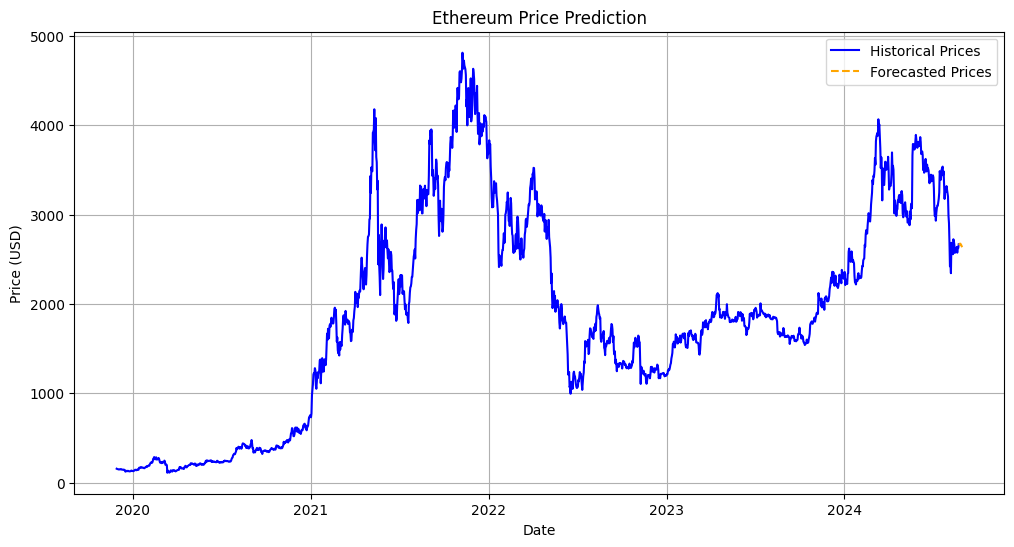

In [ ]:
import pandas as pd
import requests
import torch
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import matplotlib.pyplot as plt

# Configuration
MAX_ENCODER_LENGTH = 365
MAX_PREDICTION_LENGTH = 7
BATCH_SIZE = 128

def fetch_data():
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {'fsym': 'ETH', 'tsym': 'USD', 'limit': 1729}
    response = requests.get(url, params=params)
    data = response.json()['Data']['Data']
    df = pd.DataFrame(data, columns=['time', 'close', 'open', 'high', 'low', 'volumeto'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LightningTFT(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.model = tft_model
        self.loss = self.model.loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        y_hat = output.prediction
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss, batch_size=x['decoder_cont'].shape[0])
        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        y_hat = output.prediction
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, batch_size=x['decoder_cont'].shape[0])
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

# Fetch and prepare the data
df = fetch_data()
df['time_idx'] = (df['time'] - df['time'].min()).dt.days
df['group'] = 'eth_usd'
training_cutoff = df["time"].max() - pd.Timedelta(days=MAX_PREDICTION_LENGTH)

# Prepare the training dataset
training = TimeSeriesDataSet(
    df[lambda x: x.time <= training_cutoff],
    time_idx="time_idx",
    target="close",
    group_ids=["group"],
    min_encoder_length=MAX_ENCODER_LENGTH // 2,
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=1,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=["group"],
    time_varying_known_reals=[],
    time_varying_unknown_reals=["open", "high", "low", "volumeto", "close"],
    target_normalizer=GroupNormalizer(groups=["group"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=0)

# Use additional quantiles
tft = TemporalFusionTransformer.from_dataset(
    training,
    hidden_size=256,
    lstm_layers=2,
    dropout=0.3,
    output_size=7,
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    learning_rate=1e-4,
    hidden_continuous_size=64,
    attention_head_size=4,
    max_encoder_length=MAX_ENCODER_LENGTH,
    reduce_on_plateau_patience=4,
)

tft = tft.to(device)
lightning_tft = LightningTFT(tft)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

# Trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",  # Automatically choose GPU if available, otherwise CPU
    devices="auto",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    log_every_n_steps=1,
)

trainer.fit(lightning_tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

# Make predictions
predictions = lightning_tft.model.predict(val_dataloader, return_x=True)
predicted_prices = predictions.output.cpu().numpy()
last_known_date = df['time'].max()
future_dates = [last_known_date + pd.Timedelta(days=i+1) for i in range(predicted_prices.shape[1])]
prediction_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': predicted_prices[0]})

print(f"\nLast known price: ${df['close'].iloc[-1]:.2f}")
print("\nEthereum Price Predictions:")
print(prediction_df.to_string(index=False, float_format='${:.2f}'.format))

plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label="Historical Prices", color='blue')
plt.plot(prediction_df['Date'], prediction_df['Predicted_Price'], label="Forecasted Prices", color='orange', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Ethereum Price Prediction")
plt.legend()
plt.grid(True)
plt.show()